In [1]:
from policyengine_us import Microsimulation

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import requests
import us

import cartogram

/home/fakl/policyengine/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Micro-simulation

In [2]:
sim = Microsimulation(dataset="hf://policyengine/test/sparse_cd_stacked_2023.h5")

In [3]:
sim.calculate("income_tax")
sim.calculate("congressional_district_geoid")
sim.calculate("income_tax", map_to="household")

               value      weight
0        4587.200195   13.742280
1        4587.200195   61.547729
2       70842.179688   16.596466
3       70842.179688   34.286915
4       70842.179688   15.586526
...              ...         ...
88978   71878.273438   18.035107
88979   71878.273438  144.022263
88980  496323.446533   22.460018
88981  496323.446533   27.677790
88982  496323.446533   37.072266

[88983 rows x 2 columns]

In [4]:
df = sim.calculate_dataframe(["congressional_district_geoid","income_tax"])

In [5]:
# compute weighted income tax
df['weighted_income_tax'] = df.weights * df['income_tax']

In [6]:
# group by district, compute sum
w_income_tax = df.groupby('congressional_district_geoid')['weighted_income_tax'].sum()

In [7]:
# build district codes to download .kml files
# note that single-district states and DC need special consideration
district_code = []
single_district_states = ['DC', 'AK', 'DE', 'ND', 'SD', 'VT', 'WY']
for i in w_income_tax.index:
    state_fips = "{:02d}".format(i//100)
    state_abbr = "DC" if state_fips=="11" else us.states.lookup(state_fips).abbr
    district_id = "0" if state_abbr in single_district_states else "{:d}".format(i%100) 
    district_code.append("{}-{}".format(state_abbr, district_id))

In [9]:
file_url = "https://kml.house.gov/current/{district}/shape.kml"
local_filename = "{district}.kml"

In [ ]:
for d in district_code:
    try:
        response = requests.get(file_url.format(district=d), stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
    
        with open(local_filename.format(district=d), 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"File '{local_filename.format(district=d)}' downloaded successfully.")
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")

In [10]:
gdfs = []
for d in district_code:
    gdf = gpd.read_file(local_filename.format(district=d), driver='libkml')
    gdfs.append(gdf)
combined_gdf = pd.concat(gdfs, ignore_index=True)

In [11]:
combined_gdf['geoid'] = w_income_tax.index
combined_gdf['income_tax'] = w_income_tax.values

In [ ]:
combined_gdf.plot(column='income_tax', legend=True)

In [ ]:
impact = pd.read_csv('congressional_district_summary.csv')

impact['geoid'] = impact['congressional_district_geoid'].astype('uint32')

In [44]:
merged_df = pd.merge(combined_gdf, impact, on='geoid')

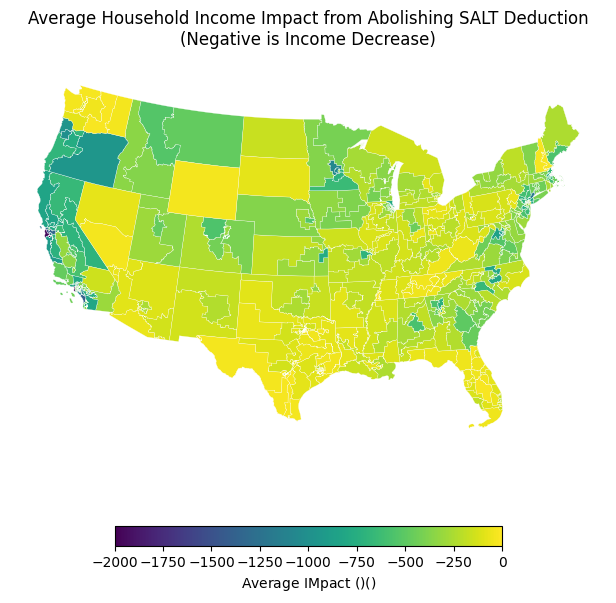

In [80]:
merged_df.query("state_fips!=2 and state_fips!=15").to_crs("ESRI:102003").plot(
    column='avg_income_impact', figsize=(10,7),
    legend=True, vmax=0, vmin=-2000, edgecolor='w', linewidth=0.2,
    legend_kwds={"label": "Average IMpact ($) ($)", "orientation": "horizontal", "shrink":0.5},
)
plt.title("Average Household Income Impact from Abolishing SALT Deduction\n(Negative is Income Decrease)")
plt.axis('off');

# Cartogram

Here, we scale (and distort) individual districts according to a variable, which could, for example, be population size. To try it out, we use income_tax.

In [26]:
# create a cartogram
# We select the districts in Alabama, because building the cartogram took rather long for the full dataset
c = cartogram.Cartogram(combined_gdf[:7], "income_tax")

<Axes: >

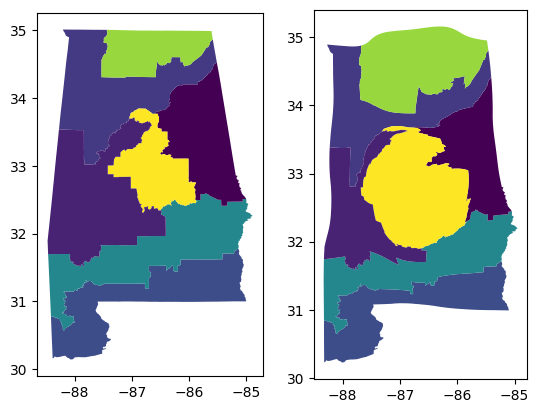

In [30]:
# plot map and cartogram, colored by income_tax
fig, ax = plt.subplots(1, 2)

combined_gdf[:7].plot(column='income_tax', ax=ax[0])
c.plot(column='income_tax', ax=ax[1])